A1.iii: „Cluster Zelltypen auf Basis ihres ATAC-Signals?“
→ Hier könntest du tSNE auf der Matrix Zelltypen × Peaks (z.B. für die wichtigsten 1000 variabelsten Peaks) laufen lassen und dann färben nach Zelltyp-Kategorie (B-Zelle, T-Zelle, Monozyt, …).
→ So siehst du, ob ähnliche Zellen eng beieinander liegen.
A2.i: „Clusterung nach Genexpression ähnlich wie nach ATAC?“
→ Hier das gleiche für die Expressionmatrix (Zelltypen × Gene).
Color Grading:

Zelltypen farbig nach ihrer Zugehörigkeit (Haupttyp, Subtyp).
Oder: Nach Expressionsniveau eines Markergens, oder nach Chromatin-Signal an bestimmten CREs (z.B. mit Farbverlauf).

A1.iv: „Cluster von CREs nach Signalprofil“
→ tSNE auf der Peak × Zelltyp-Matrix, dann färben nach:
Distanz zur TSS (Farbverlauf von nah zu weit),
CRE-Kategorie (Promoter/Enhancer),
Signal-Statistik (z.B. mean oder variability, Farbverlauf).

A2.ii: „Gene nach Expressionsprofil clustern“
→ tSNE auf Gene × Zelltypen und färben nach Zugehörigkeit zu Genfamilien oder Expressionshöhe.

Du möchtest wissen, wo assoziierte CREs relativ zur TSS liegen und wie ihre chromatin-offene Signalstärke mit der Expression assoziiert ist.

Beispiel für eine tSNE-Visualisierung:
Jede CRE (Peak) ist ein Punkt im tSNE-Plot (Dimensionen: Zelltypen, d.h. Matrix = CREs × Zelltypen).
Farbe jedes Punktes = Distanz zur TSS (Color-Grading, z.B. gelb = nahe, lila = weit).
Ergebnis:
Du erkennst, ob CREs mit ähnlicher TSS-Distanz ähnliche Chromatin-Signale über die Zelltypen zeigen (z.B. sind Promoter-nah mehr gruppiert?).

In [1]:
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import sklearn.manifold as sklm
import os
from sklearn.decomposition import PCA
import scanpy as sc
import functions
importlib.reload(functions)
functions.set_user('Laila')
data = functions.call_data_clean()
ATAC = data['ATAC_seq']
RNA = data['RNA_seq']
QC = data['QC_metrics']
ATAC_scores = data['norm_scores']
exons = data['exons']
ATACtest = data['test1']
ATAC_dis = pd.read_csv("ATAC_dis_annotated.csv", header=0, index_col=0)
score_cols_all = list(data['norm_scores'].columns)

In [2]:
print(list(ATAC_dis.columns))
score_cols_all = list(data['norm_scores'].columns)
print(score_cols_all)

['chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM', 'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp', 'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp', 'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th', 'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.Th', 'Tgd.g1.1+d1.LN', 'Tgd.Sp', 'NK.27+11b-.BM', 'NK.27

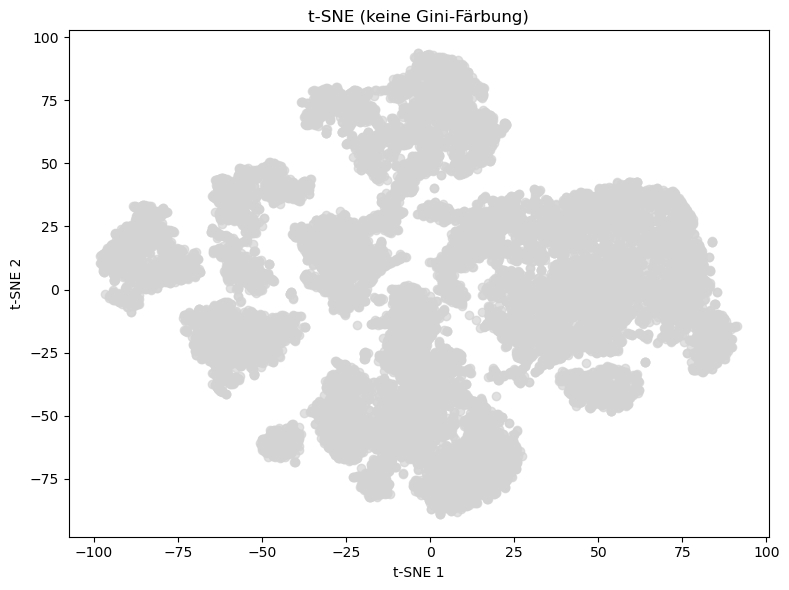

In [3]:
N = 20000
top_peaks_idx = ATAC_dis['variability'].sort_values(ascending=False).head(N).index
#top_peaks_matrix = ATAC_dis.loc[top_peaks_idx, :]

# 4. TSS-Distanz für diese Peaks holen (matching Index!)
tss_distances = ATAC_dis.loc[top_peaks_idx, 'distance_to_TSS'].values

# 5. tSNE anwenden
coords = functions.tSNE(ATAC_dis, score_cols_all, 25, 30, top_peaks_idx)[0]

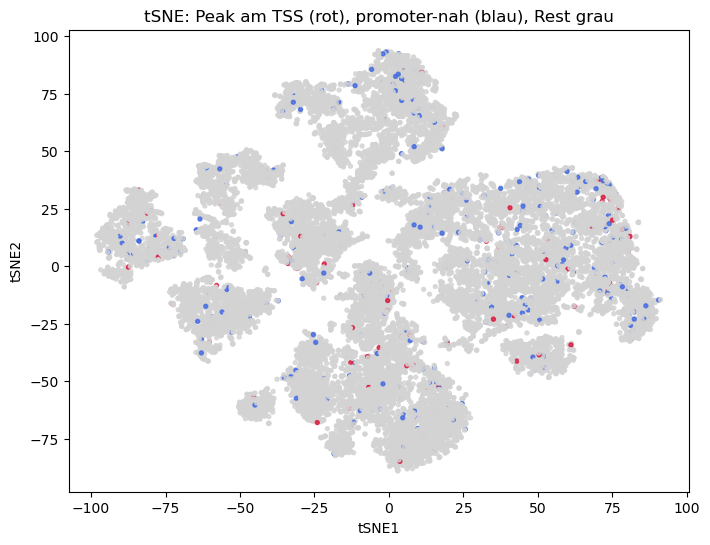

In [25]:
tss_names = ATAC_dis.loc[coords.index, 'TSS']
colors = np.full_like(tss_distances, fill_value='lightgrey', dtype='object')

# ROT: Peak direkt am TSS (dort, wo 'TSS' NICHT NaN ist)
colors[~pd.isna(tss_names)] = 'crimson'

# BLAU: 0 < Distanz <= 2000, aber KEIN direkter TSS (also TSS ist NaN)
mask_blue = (tss_distances > 0) & (tss_distances <= 2000) & (pd.isna(tss_names))
colors[mask_blue] = 'royalblue'

plt.figure(figsize=(8,6))
plt.scatter(coords['tSNE1'], coords['tSNE2'], c=colors, s=8, alpha=0.8)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.title('tSNE: Peak am TSS (rot), promoter-nah (blau), Rest grau')
plt.show()

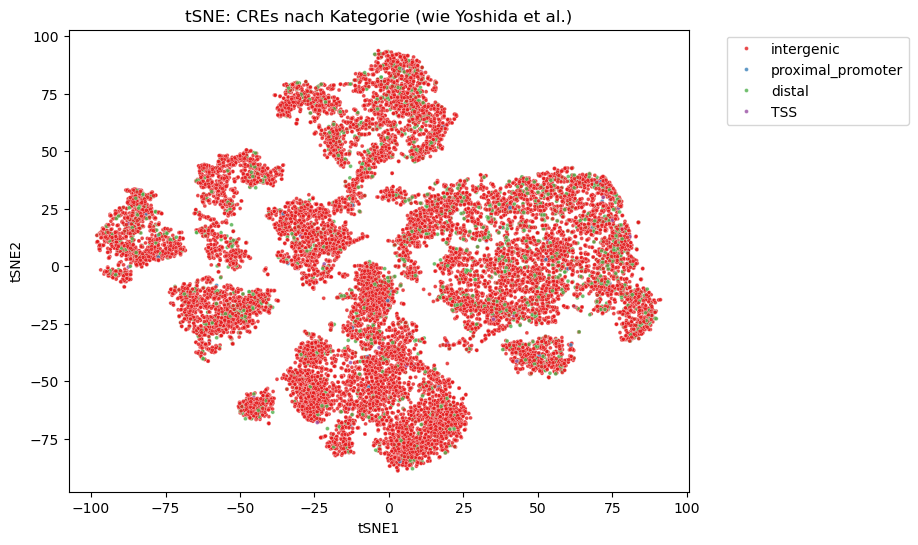

In [27]:
bins = [
    (-np.inf, 0),         # direkt am/im TSS
    (0, 500),             # promoter-proximal
    (500, 2000),          # promoter-nah
    (2000, 10000),        # distal
    (10000, np.inf)       # weit weg
]
labels = ['TSS', 'proximal_promoter', 'promoter_near', 'distal', 'intergenic']

def cat(dist, tss):
    if not pd.isna(tss):
        if dist <= 0:
            return 'TSS'
        elif dist <= 500:
            return 'proximal_promoter'
        elif dist <= 2000:
            return 'promoter_near'
    if dist > 2000 and dist <= 10000:
        return 'distal'
    return 'intergenic'

categories = [cat(d, t) for d, t in zip(tss_distances, tss_names)]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords['tSNE1'], y=coords['tSNE2'],
    hue=categories, palette='Set1', s=8, alpha=0.8
)
plt.title('tSNE: CREs nach Kategorie (wie Yoshida et al.)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

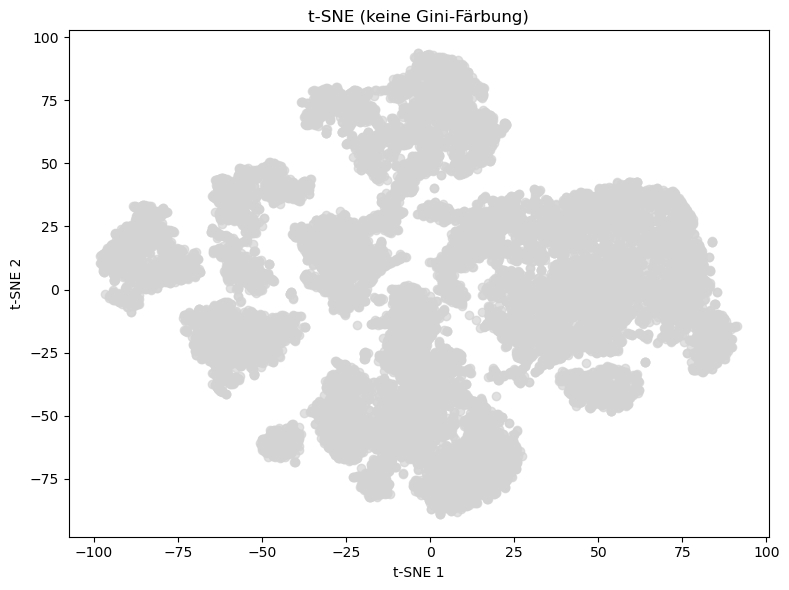

In [7]:
ATAC_dis_prom1kb = ATAC_dis.copy()
ATAC_dis_prom1kb['region_type'] = np.where(ATAC_dis_prom1kb['distance_to_TSS'].abs() <= 1000, 'Promoter', 'Enhancer')
tsne_yosh, gini_score = functions.tSNE(ATAC_dis, score_cols_all, 25, 30, top_peaks_idx)

ValueError: 'c' argument has 90 elements, which is inconsistent with 'x' and 'y' with size 20000.

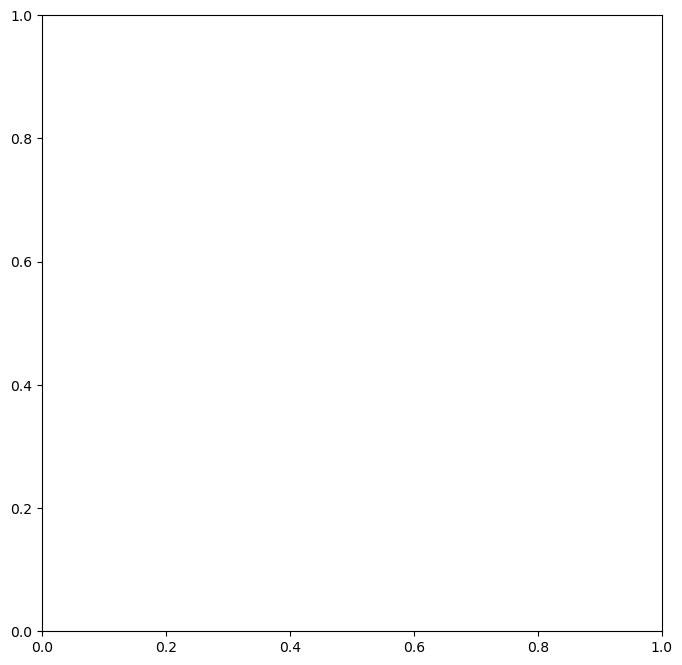

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(tsne_yosh['tSNE1'], tsne_yosh['tSNE2'], c=gini_score, cmap='Spectral', s=4)
plt.colorbar(label="Gini index\n(Cell-type specificity)")
plt.title('tSNE: CREs nach Gini-Index (Yoshida-Style)')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.show()